# Problem II: Image Classification with Convolutional Neural Networks

**Learning Objectives**

In this notebook, we explore **image classification** using **Convolutional Neural Networks (CNNs)** — one of the most successful applications of deep learning. We will work with the **Fashion-MNIST** dataset, a modern replacement for the classic MNIST digits.

We will:
1. **Download** the Fashion-MNIST dataset from the internet
2. **Transform** images into PyTorch tensors with proper normalization
3. **Organize** data using `Dataset` and `DataLoader` for efficient training
4. (Later) Build and compare different CNN architectures
5. (Later) Train with various optimizers and analyze results

**Key Takeaway**: Understanding the data pipeline (download → transform → load) is foundational. A well-structured data pipeline enables reproducible experiments and efficient training.

# Step 1: Preparing the Data

## 1. Introduction: What is Image Classification?

**1.1 The Task**

**Image classification** is the task of assigning a label to an image from a fixed set of categories. Mathematically, we seek a function:

$$f_{\theta}: \mathcal{X} \rightarrow \mathcal{Y}$$

where:
- $\mathcal{X} = \mathbb{R}^{H \times W \times C}$ is the space of images (height $H$, width $W$, channels $C$)
- $\mathcal{Y} = \{0, 1, ..., K-1\}$ is the set of $K$ class labels
- $\theta$ are the learnable parameters of our model

For Fashion-MNIST:
- Images are grayscale: $H = W = 28$, $C = 1$
- There are $K = 10$ classes (T-shirt, Trouser, Pullover, etc.)

**1.2 Why Fashion-MNIST?**

The original MNIST (handwritten digits) has become too easy for modern methods, with accuracies exceeding 99.7%. Fashion-MNIST provides:

| Property | MNIST | Fashion-MNIST |
|----------|-------|---------------|
| Image size | 28×28 | 28×28 |
| Channels | 1 (grayscale) | 1 (grayscale) |
| Training samples | 60,000 | 60,000 |
| Test samples | 10,000 | 10,000 |
| Classes | 10 (digits 0-9) | 10 (clothing items) |
| Difficulty | Easy | Moderate |

**1.3 Why Convolutional Neural Networks?**

Standard fully-connected networks treat images as flat vectors, **ignoring** spatial structure. A 28×28 image becomes a 784-dimensional vector, **losing** the information that neighboring pixels are related.

**CNNs exploit spatial locality** through:
1. **Local connectivity**: Each neuron connects only to a local region
2. **Parameter sharing**: The same filter is applied across the entire image
3. **Translation equivariance**: A shifted input produces a shifted output

This makes CNNs dramatically more efficient and effective for image data.

## 2. Downloading the Data

**2.1 The Mathematical Setup**

Our dataset $\mathcal{D}$ consists of $N$ labeled examples:

$$\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{N}$$

where:
- $\mathbf{x}^{(i)} \in \mathbb{R}^{28 \times 28}$ is the $i$-th image (pixel values in $[0, 255]$)
- $y^{(i)} \in \{0, 1, ..., 9\}$ is the corresponding class label

**2.2 PyTorch's torchvision.datasets**

PyTorch provides `torchvision.datasets` , a collection of popular datasets with automatic downloading capabilities. The key parameters are:

```python
FashionMNIST(
    root,        # Directory to store the data
    train,       # True for training set, False for test set
    download,    # True to download if not present
    transform    # Transformations to apply to images
)
```

**2.3 The Fashion-MNIST Classes**

| Label | Description |
|-------|-------------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Used device is {device}')

Used device is mps


In [2]:
# Define the data directory
DATA_DIR = './data'

# Download Fashion-MNIST (without transforms for now, we'll add them in Section 3)
# This downloads ~30 MB of data
train_dataset_raw = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,           # Training set (60,000 images)
    download=True,        # Download if not already present
    transform=None        # No transform yet - raw PIL images
)

test_dataset_raw = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,          # Test set (10,000 images)
    download=True,
    transform=None
)

print(f"Training set size: {len(train_dataset_raw):,} images")
print(f"Test set size: {len(test_dataset_raw):,} images")

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:17<00:00, 1.48MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 183kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:03<00:00, 1.46MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 3.57MB/s]

Training set size: 60,000 images
Test set size: 10,000 images


In [3]:
# Define class names for interpretation
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Examine a single sample
sample_image, sample_label = train_dataset_raw[0]

print("="*60)
print("EXAMINING RAW DATA")
print("="*60)
print(f"\nImage type: {type(sample_image)}")
print(f"Image size: {sample_image.size}")
print(f"Image mode: {sample_image.mode}")
print(f"\nLabel: {sample_label}")
print(f"Class name: {CLASS_NAMES[sample_label]}")

EXAMINING RAW DATA

Image type: <class 'PIL.Image.Image'>
Image size: (28, 28)
Image mode: L

Label: 9
Class name: Ankle boot


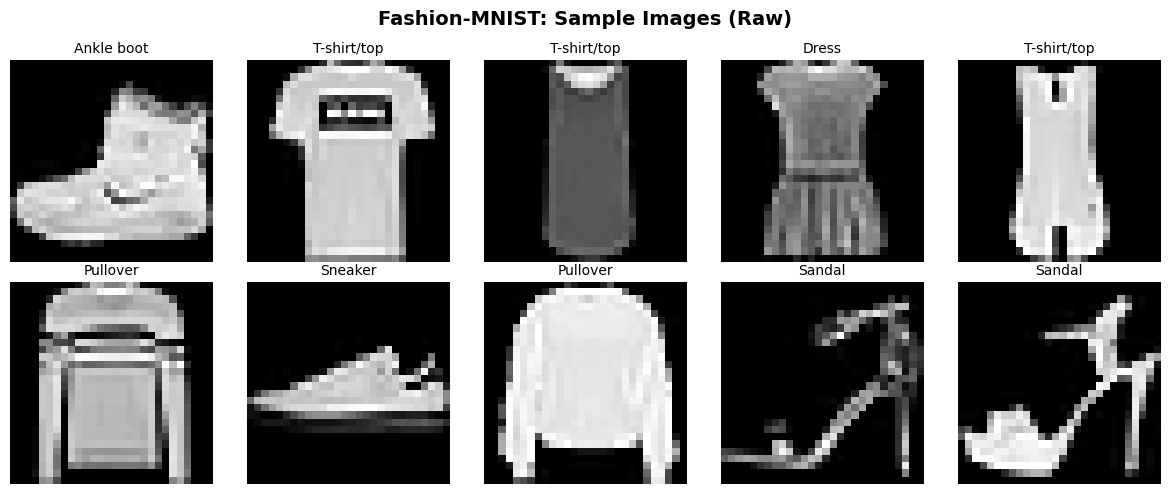

In [4]:
# Visualize some samples from the raw dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Fashion-MNIST: Sample Images (Raw)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_raw[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{CLASS_NAMES[label]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

**2.4 Understanding the Raw Data**

**Key Observations:**

1. **Format**: Raw images are PIL (Python Imaging Library) objects, not tensors
2. **Size**: Each image is 28×28 pixels
3. **Mode**: Grayscale ('L' mode = 8-bit pixels, range 0-255)
4. **Labels**: Integer indices 0-9 corresponding to class names

**Why can't we train directly on this?**

PyTorch neural networks require:
- Input as `torch.Tensor`, not PIL images
- Proper shape: `(batch_size, channels, height, width)` for CNNs
- Normalized values for stable training

This motivates Section 3: Transformations.

## 3. Transforming Images to PyTorch Tensors

**3.1 The Transformation Pipeline**

A **transform** is a function $T: \mathcal{X}_{\text{raw}} \rightarrow \mathcal{X}_{\text{processed}}$ that converts raw data into a format suitable for training. For images, we typically compose multiple transforms:

$$T = T_n \circ T_{n-1} \circ \cdots \circ T_1$$

In PyTorch, this is done with `transforms.Compose([T_1, T_2, ..., T_n])`.

**3.2 Essential Transforms**


**3.2.1 `ToTensor()`**

Converts a PIL Image or numpy array to a PyTorch tensor:

$$\text{ToTensor}: \text{PIL Image}_{H \times W} \rightarrow \text{Tensor}_{C \times H \times W}$$

**Crucially**, it also:
- Reorders dimensions from $(H, W, C)$ to $(C, H, W)$ (PyTorch convention)
- Rescales pixel values from $[0, 255]$ to $[0.0, 1.0]$ by dividing by 255


**3.2.2 `Normalize(mean, std)`**

Applies **standardization** (z-score normalization) to each channel:

$$\hat{x}_c = \frac{x_c - \mu_c}{\sigma_c}$$

where:
- $x_c$ is a pixel value in channel $c$
- $\mu_c$ is the mean of channel $c$ (computed over the training set)
- $\sigma_c$ is the standard deviation of channel $c$

**Why normalize?**

1. **Faster convergence**: Normalized inputs have similar scales, helping gradient descent
2. **Numerical stability**: Prevents very large or very small activations
3. **Better conditioning**: The loss landscape becomes more spherical

**3.3 Computing Dataset Statistics**

For proper normalization, we need the mean $\mu$ and standard deviation $\sigma$ of the training set. For Fashion-MNIST (single channel), we compute:

$$\mu = \frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} x^{(i)}_{h,w}$$

$$\sigma = \sqrt{\frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} (x^{(i)}_{h,w} - \mu)^2}$$

In [5]:
# First, let's compute the mean and std of Fashion-MNIST
# We need to load data as tensors (without normalization) to compute statistics

temp_transform = transforms.ToTensor()  # Only convert to tensor, values in [0, 1]

temp_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=False,
    transform=temp_transform
)

# Stack all images into a single tensor for efficient computation
# This creates a tensor of shape (60000, 1, 28, 28)
all_images = torch.stack([img for img, _ in temp_dataset])

print(f"All images shape: {all_images.shape}")
print(f"Memory usage: {all_images.numel() * 4 / 1e6:.1f} MB (float32)")

All images shape: torch.Size([60000, 1, 28, 28])
Memory usage: 188.2 MB (float32)


In [6]:
# Compute mean and std over all pixels
# Mean: average over all images (dim 0), all pixels (dims 2, 3)
mean = all_images.mean(dim=(0, 2, 3))  # Shape: (1,) for 1 channel
std = all_images.std(dim=(0, 2, 3))    # Shape: (1,) for 1 channel

print("="*60)
print("FASHION-MNIST STATISTICS")
print("="*60)
print(f"\nMean (μ): {mean.item():.4f}")
print(f"Std (σ):  {std.item():.4f}")
print(f"\nAfter normalization:")
print(f"  - Values will be centered around 0")
print(f"  - Most values will be in range [{-3*std.item():.2f}, {3*std.item():.2f}]")

# Store for later use
FASHION_MNIST_MEAN = (mean.item(),)
FASHION_MNIST_STD = (std.item(),)

FASHION-MNIST STATISTICS

Mean (μ): 0.2860
Std (σ):  0.3530

After normalization:
  - Values will be centered around 0
  - Most values will be in range [-1.06, 1.06]


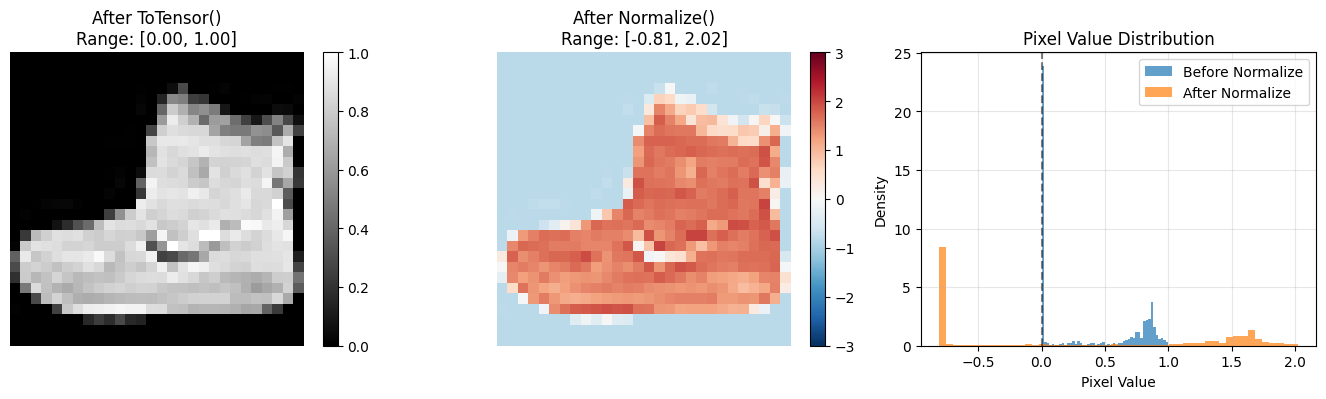

In [7]:
# Visualize the effect of normalization
sample_tensor = all_images[0]  # Shape: (1, 28, 28)

# Apply normalization manually
sample_normalized = (sample_tensor - mean.view(1, 1, 1)) / std.view(1, 1, 1)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original (after ToTensor, before Normalize)
ax = axes[0]
im = ax.imshow(sample_tensor.squeeze(), cmap='gray')
ax.set_title(f'After ToTensor()\nRange: [{sample_tensor.min():.2f}, {sample_tensor.max():.2f}]')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Normalized
ax = axes[1]
im = ax.imshow(sample_normalized.squeeze(), cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title(f'After Normalize()\nRange: [{sample_normalized.min():.2f}, {sample_normalized.max():.2f}]')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Histogram comparison
ax = axes[2]
ax.hist(sample_tensor.flatten().numpy(), bins=50, alpha=0.7, label='Before Normalize', density=True)
ax.hist(sample_normalized.flatten().numpy(), bins=50, alpha=0.7, label='After Normalize', density=True)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Density')
ax.set_title('Pixel Value Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**3.4 Creating the Complete Transform Pipeline**

Now we define our complete transformation:

$$T = \text{Normalize} \circ \text{ToTensor}$$

In code:
```python
transform = transforms.Compose([
    transforms.ToTensor(),                    # PIL → Tensor, [0,255] → [0,1]
    transforms.Normalize(mean, std)           # Standardization
])
```

**Important**: 
- Apply the **same** transform to both training and test data
- Use statistics computed **only from training data** (to prevent data leakage)

In [8]:
# Define the complete transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor, scale to [0, 1]
    transforms.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)  # Standardize
])

print("Transform pipeline:")
print(transform)
print(f"\nUsing mean={FASHION_MNIST_MEAN}, std={FASHION_MNIST_STD}")

Transform pipeline:
Compose(
    ToTensor()
    Normalize(mean=(0.28604060411453247,), std=(0.3530242443084717,))
)

Using mean=(0.28604060411453247,), std=(0.3530242443084717,)


In [9]:
# Create datasets with the transform applied
train_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=False,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=False,
    transform=transform
)

# Verify the transformation
sample_tensor, sample_label = train_dataset[0]

print("="*60)
print("TRANSFORMED DATA VERIFICATION")
print("="*60)
print(f"\nTensor type: {type(sample_tensor)}")
print(f"Tensor dtype: {sample_tensor.dtype}")
print(f"Tensor shape: {sample_tensor.shape}  (C, H, W)")
print(f"\nValue range: [{sample_tensor.min():.3f}, {sample_tensor.max():.3f}]")
print(f"Mean: {sample_tensor.mean():.3f}")
print(f"Std: {sample_tensor.std():.3f}")
print(f"\nLabel: {sample_label} ({CLASS_NAMES[sample_label]})")

TRANSFORMED DATA VERIFICATION

Tensor type: <class 'torch.Tensor'>
Tensor dtype: torch.float32
Tensor shape: torch.Size([1, 28, 28])  (C, H, W)

Value range: [-0.810, 2.022]
Mean: 0.270
Std: 1.131

Label: 9 (Ankle boot)


**3.5 Summary: From PIL Image to Normalized Tensor**

The complete transformation pipeline:

```
PIL Image          ToTensor()           Normalize(μ, σ)
─────────────  ─────────────────────►  ─────────────────────►  PyTorch Tensor
• H×W pixels       • Shape: (1, 28, 28)    • Shape: (1, 28, 28)
• Values: 0-255    • Values: [0, 1]        • Values: centered at 0
• uint8            • float32               • float32
```

**What we achieved:**
- ✅ Converted PIL images to PyTorch tensors
- ✅ Correct shape for CNN: `(channels, height, width)`
- ✅ Normalized values for stable training

## 4. Shuffling, Splitting, and Loading Data

**4.1 Why Do We Need Training and Validation Sets?**

In machine learning, we split our data into:

| Set | Purpose | Usage |
|-----|---------|-------|
| **Training** | Learn parameters $\theta$ | Compute gradients, update weights |
| **Validation** | Tune hyperparameters, monitor overfitting | Evaluate without training |
| **Test** | Final unbiased evaluation | Report results (use only once!) |

The **validation set** is crucial for:
1. **Early stopping**: Stop training when validation loss stops improving
2. **Hyperparameter selection**: Choose learning rate, architecture, etc.
3. **Overfitting detection**: Training loss decreasing while validation loss increases

**4.2 The Mathematics of Data Splitting**

Given a dataset $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{N}$, we partition it into disjoint subsets:

$$\mathcal{D} = \mathcal{D}_{\text{train}} \cup \mathcal{D}_{\text{val}} \cup \mathcal{D}_{\text{test}}$$

with $\mathcal{D}_{\text{train}} \cap \mathcal{D}_{\text{val}} = \emptyset$, etc.

Common split ratios:
- Training: 80% (48,000 images)
- Validation: 20% (12,000 images)  
- Test: Separate (10,000 images — already provided)

**4.3 Why Shuffle?**

**Shuffling** randomizes the order of training samples. This is critical because:

1. **Breaks correlations**: If data is ordered (e.g., all class 0, then all class 1...), the network might learn spurious patterns

2. **Better gradient estimates**: Mini-batch gradients are noisy estimates of the true gradient. Shuffling ensures each batch is representative:

$$\nabla_{\theta} \mathcal{L}(\theta) \approx \frac{1}{|B|} \sum_{i \in B} \nabla_{\theta} \ell(f_\theta(\mathbf{x}^{(i)}), y^{(i)})$$

where $B$ is a randomly sampled mini-batch.

3. **Regularization effect**: Different orderings each epoch act as a form of regularization

**Important**: 
- Shuffle **training data**: Yes (every epoch)
- Shuffle **validation/test data**: No (for reproducibility)

**Terminology Note**: Fashion-MNIST comes pre-split into train=True (60,000) and train=False (10,000). The train=False portion is the held-out test set we'll use for final evaluation. We further split the train=True portion into our working training set (48,000) and validation set (12,000). This gives us three disjoint sets.

In [10]:
# Split the training set into training and validation
# Fashion-MNIST provides 60,000 training images
# We'll use 80% for training (48,000) and 20% for validation (12,000)

TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(train_dataset))
val_size = len(train_dataset) - train_size

print(f"Original training set: {len(train_dataset):,} images")
print(f"Split ratio: {TRAIN_RATIO:.0%} train / {1-TRAIN_RATIO:.0%} validation")
print(f"\nAfter split:")
print(f"  Training:   {train_size:,} images")
print(f"  Validation: {val_size:,} images")
print(f"  Test:       {len(test_dataset):,} images (separate)")

Original training set: 60,000 images
Split ratio: 80% train / 20% validation

After split:
  Training:   48,000 images
  Validation: 12,000 images
  Test:       10,000 images (separate)


In [11]:
# Perform the split using random_split
# This creates two Subset objects that reference the original dataset
# The split is randomized based on the generator seed

generator = torch.Generator().manual_seed(42)  # For reproducibility

train_subset, val_subset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator
)

print(f"Train subset type: {type(train_subset)}")
print(f"Train subset size: {len(train_subset)}")
print(f"Val subset size: {len(val_subset)}")

Train subset type: <class 'torch.utils.data.dataset.Subset'>
Train subset size: 48000
Val subset size: 12000


**4.4 DataLoader: Efficient Batched Data Loading**

The `DataLoader` is PyTorch's utility for:
1. **Batching**: Grouping samples into mini-batches
2. **Shuffling**: Randomizing order each epoch
3. **Parallel loading**: Using multiple workers for speed
4. **Memory efficiency**: Loading data on-demand

**4.4.1 Mini-Batch Gradient Descent**

Instead of computing gradients over the entire dataset (**batch gradient descent**) or single samples (**stochastic gradient descent**), we use **mini-batches** of size $B$:

$$\theta \leftarrow \theta - \eta \cdot \frac{1}{B} \sum_{i=1}^{B} \nabla_\theta \ell(f_\theta(\mathbf{x}^{(i)}), y^{(i)})$$

| Method | Batch Size | Pros | Cons |
|--------|------------|------|------|
| Batch GD | $N$ (all) | Stable, accurate gradient | Slow, memory-intensive |
| SGD | 1 | Fast updates, escapes minima | Noisy, unstable |
| Mini-batch | $B$ (e.g., 32-256) | Best of both worlds | Requires tuning $B$ |

**4.4.2 DataLoader Parameters**

```python
DataLoader(
    dataset,         # The dataset to load from
    batch_size,      # Number of samples per batch
    shuffle,         # Whether to shuffle at each epoch
    num_workers,     # Parallel data loading processes
    pin_memory,      # Speed up CPU-to-GPU transfer
    drop_last        # Drop incomplete final batch
)
```

In [12]:
# Define batch size - a crucial hyperparameter
BATCH_SIZE = 64

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle training data each epoch
    num_workers=2,          # Parallel data loading (adjust based on your system)
    pin_memory=True         # Faster CPU→GPU transfer if using CUDA
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle validation data
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle test data
    num_workers=2,
    pin_memory=True
)

print("="*60)
print("DATALOADER CONFIGURATION")
print("="*60)
print(f"\nBatch size: {BATCH_SIZE}")
print(f"\nNumber of batches:")
print(f"  Training:   {len(train_loader):,} batches × {BATCH_SIZE} = {len(train_loader)*BATCH_SIZE:,} samples/epoch")
print(f"  Validation: {len(val_loader):,} batches")
print(f"  Test:       {len(test_loader):,} batches")

DATALOADER CONFIGURATION

Batch size: 64

Number of batches:
  Training:   750 batches × 64 = 48,000 samples/epoch
  Validation: 188 batches
  Test:       157 batches


In [13]:
# Examine a single batch
# iter() creates an iterator, next() gets the first batch
sample_batch_images, sample_batch_labels = next(iter(train_loader))

print("="*60)
print("EXAMINING A SINGLE BATCH")
print("="*60)
print(f"\nImages tensor shape: {sample_batch_images.shape}")
print(f"  → (batch_size, channels, height, width)")
print(f"  → ({BATCH_SIZE}, 1, 28, 28)")
print(f"\nLabels tensor shape: {sample_batch_labels.shape}")
print(f"Labels dtype: {sample_batch_labels.dtype}")
print(f"\nSample labels: {sample_batch_labels[:10].tolist()}")
print(f"Class names: {[CLASS_NAMES[l] for l in sample_batch_labels[:10].tolist()]}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EXAMINING A SINGLE BATCH

Images tensor shape: torch.Size([64, 1, 28, 28])
  → (batch_size, channels, height, width)
  → (64, 1, 28, 28)

Labels tensor shape: torch.Size([64])
Labels dtype: torch.int64

Sample labels: [9, 8, 2, 6, 9, 0, 3, 5, 2, 1]
Class names: ['Ankle boot', 'Bag', 'Pullover', 'Shirt', 'Ankle boot', 'T-shirt/top', 'Dress', 'Sandal', 'Pullover', 'Trouser']


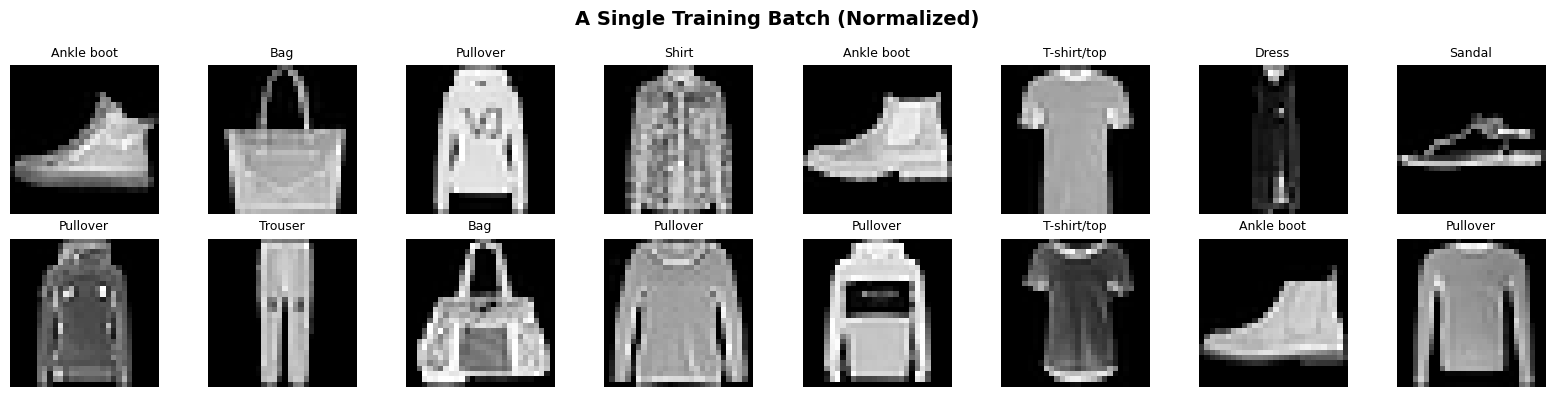

In [14]:
# Visualize a batch of normalized images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('A Single Training Batch (Normalized)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Denormalize for visualization: x = x * std + mean
    img = sample_batch_images[i].squeeze()  # Remove channel dimension
    img_denorm = img * FASHION_MNIST_STD[0] + FASHION_MNIST_MEAN[0]
    
    ax.imshow(img_denorm.numpy(), cmap='gray')
    ax.set_title(f'{CLASS_NAMES[sample_batch_labels[i]]}', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

**4.5 Verifying Class Distribution**

A good data split should maintain the **class distribution** (stratification). Let's verify that our random split didn't accidentally create an imbalanced training or validation set.

In [15]:
# Count class distribution in each split
def count_classes(subset, num_classes=10):
    """Count the number of samples per class in a subset."""
    counts = torch.zeros(num_classes, dtype=torch.int64)
    for _, label in subset:
        counts[label] += 1
    return counts

print("Computing class distributions")
train_counts = count_classes(train_subset)
val_counts = count_classes(val_subset)
test_counts = count_classes(test_dataset)

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"\n{'Class':<15} {'Train':>10} {'Val':>10} {'Test':>10}")
print("-"*45)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<15} {train_counts[i]:>10,} {val_counts[i]:>10,} {test_counts[i]:>10,}")
print("-"*45)
print(f"{'Total':<15} {train_counts.sum():>10,} {val_counts.sum():>10,} {test_counts.sum():>10,}")

Computing class distributions

CLASS DISTRIBUTION

Class                Train        Val       Test
---------------------------------------------
T-shirt/top          4,732      1,268      1,000
Trouser              4,752      1,248      1,000
Pullover             4,825      1,175      1,000
Dress                4,852      1,148      1,000
Coat                 4,807      1,193      1,000
Sandal               4,797      1,203      1,000
Shirt                4,788      1,212      1,000
Sneaker              4,866      1,134      1,000
Bag                  4,805      1,195      1,000
Ankle boot           4,776      1,224      1,000
---------------------------------------------
Total               48,000     12,000     10,000


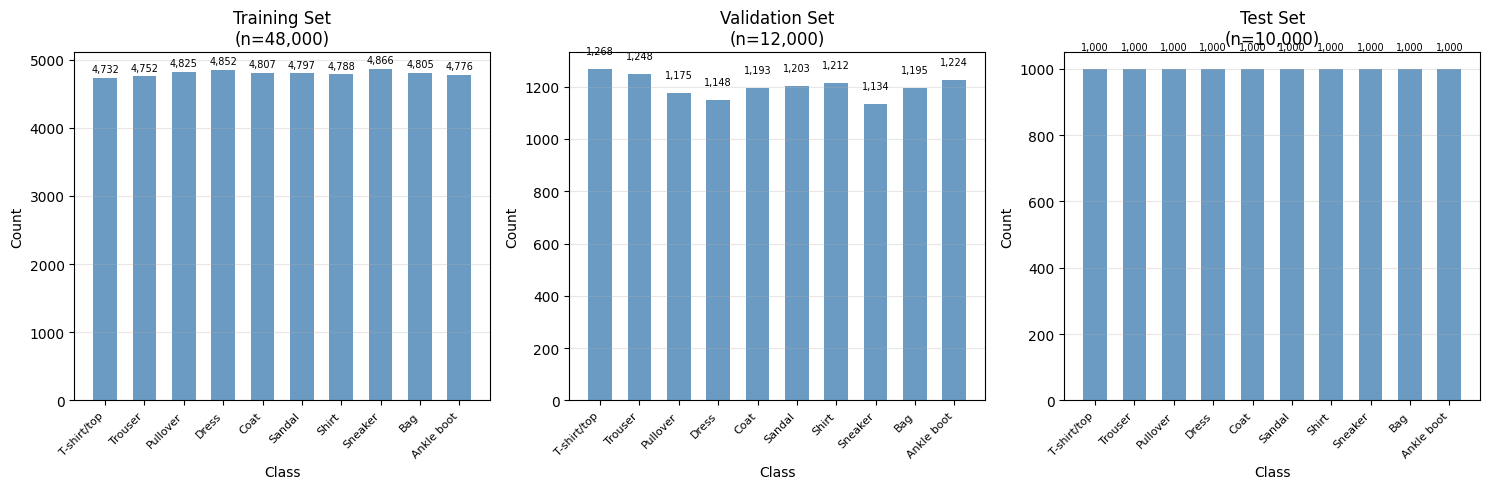


✓ The class distribution is approximately balanced across all splits.
  This is expected since Fashion-MNIST is originally balanced (6,000 per class in train).


In [16]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(len(CLASS_NAMES))
width = 0.6

for ax, counts, title in zip(axes, 
                              [train_counts, val_counts, test_counts],
                              ['Training Set', 'Validation Set', 'Test Set']):
    bars = ax.bar(x, counts.numpy(), width, color='steelblue', alpha=0.8)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{title}\n(n={counts.sum():,})')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

print("\n✓ The class distribution is approximately balanced across all splits.")
print("  This is expected since Fashion-MNIST is originally balanced (6,000 per class in train).")

**4.6 The Training Loop Preview**

Now that we have our DataLoaders set up, here's how they will be used in training:

```python
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_images, batch_labels in train_loader:  # Automatically shuffled!
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass, loss, backward pass, optimizer step
        ...
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:  # Not shuffled
            # Compute validation metrics
            ...
```

In [17]:
# Demonstrate that training data is shuffled each epoch
print("Demonstrating shuffling behavior:")
print("="*60)

# Get first batch labels from two different "epochs" (iterations over the loader)
first_epoch_labels = next(iter(train_loader))[1][:10].tolist()
second_epoch_labels = next(iter(train_loader))[1][:10].tolist()

print(f"\nFirst 10 labels (epoch 1):  {first_epoch_labels}")
print(f"First 10 labels (epoch 2):  {second_epoch_labels}")
print(f"\nAre they the same? {first_epoch_labels == second_epoch_labels}")
print("\n→ Each epoch sees the data in a different (random) order!")

Demonstrating shuffling behavior:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



First 10 labels (epoch 1):  [4, 3, 5, 0, 1, 5, 5, 7, 6, 3]
First 10 labels (epoch 2):  [0, 4, 5, 6, 2, 2, 9, 0, 6, 1]

Are they the same? False

→ Each epoch sees the data in a different (random) order!


## 5. Summary: The Complete Data Pipeline


We have established a complete data pipeline for image classification:
```
┌─────────────────────────────────────────────────────────────────────────────┐
│                           DATA PIPELINE OVERVIEW                            │
└─────────────────────────────────────────────────────────────────────────────┘

    Internet                   Local Storage              PyTorch Dataset
    ────────                   ─────────────              ───────────────
    Fashion-MNIST    download     ./data/        transform    train_dataset (60,000)
    (compressed)  ───────────►  (raw files)  ─────────────►  test_dataset  (10,000)
                                                                   │
                                                    ┌──────────────┴──────────────┐
                                                    │                             │
                                                    ▼                             │
                                             train_dataset                        │
                                                    │                             │
                                                    │ random_split                │
                                                    ▼                             │
                                          ┌─────────────────┐                     │
                                          │ train_subset    │                     │
                                          │ (48,000)        │                     │
                                          ├─────────────────┤                     │
                                          │ val_subset      │                     │
                                          │ (12,000)        │                     │
                                          └─────────────────┘                     │
                                                    │                             │
                                                    │ DataLoader                  │ DataLoader
                                                    ▼                             ▼
                                          ┌─────────────────────────────────────────┐
                                          │ train_loader (shuffle=True)             │
                                          │ val_loader   (shuffle=False)            │
                                          │ test_loader  (shuffle=False)            │
                                          └─────────────────────────────────────────┘
                                                              │
                                                              │ for batch in loader
                                                              ▼
                                                    ┌─────────────────┐
                                                    │     BATCHES     │
                                                    │ (64, 1, 28, 28) │
                                                    └─────────────────┘
```


**Key Takeaways**

| Step | What We Did | Why It Matters |
|------|-------------|----------------|
| **Download** | `FashionMNIST(download=True)` | Automatic data acquisition |
| **Transform** | `ToTensor()` + `Normalize()` | Correct format & scale for NNs |
| **Split** | `random_split(train, [80%, 20%])` | Separate train/val for monitoring |
| **Load** | `DataLoader(shuffle=True)` | Efficient batched iteration |

**Dataset Sizes**

| Set | Samples | Batches (size 64) | Purpose |
|-----|---------|-------------------|----------|
| Training | 48,000 | 750 | Learn parameters |
| Validation | 12,000 | 188 | Monitor & tune |
| Test | 10,000 | 157 | Final evaluation |

**Next Steps**

With our data pipeline complete, we are ready to:
1. Build CNN architectures
2. Train with various optimizers
3. Evaluate and compare results

In [18]:
# Final verification: Print all key variables
print("="*60)
print("DATA PIPELINE READY FOR TRAINING")
print("="*60)
print(f"\n✓ Device: {device}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Image shape: (1, 28, 28)")
print(f"✓ Number of classes: {len(CLASS_NAMES)}")
print(f"✓ Normalization: mean={FASHION_MNIST_MEAN[0]:.4f}, std={FASHION_MNIST_STD[0]:.4f}")
print(f"\n✓ train_loader: {len(train_loader)} batches ({len(train_subset):,} samples)")
print(f"✓ val_loader: {len(val_loader)} batches ({len(val_subset):,} samples)")
print(f"✓ test_loader: {len(test_loader)} batches ({len(test_dataset):,} samples)")
print(f"\n" + "="*60)
print("Ready for model building and training!")
print("="*60)

DATA PIPELINE READY FOR TRAINING

✓ Device: mps
✓ Batch size: 64
✓ Image shape: (1, 28, 28)
✓ Number of classes: 10
✓ Normalization: mean=0.2860, std=0.3530

✓ train_loader: 750 batches (48,000 samples)
✓ val_loader: 188 batches (12,000 samples)
✓ test_loader: 157 batches (10,000 samples)

Ready for model building and training!
